# analysis
Analyzing each type of quantum among exponential, uniform, and constant

In [1]:
from glob import glob
import sys, os
import matplotlib.pyplot as plt
import pickle
import numpy as np
import desutils
from functools import reduce
from matplotlib.lines import Line2D

In [92]:
cpu3    = "batchInteractive_ConstantQ_3cpu/"
cpu1    = "batchInteractive_1cpu/"
rl_cpu1 = "batchInteractive_1cpu_rl/"
rl_cpu3 = 'batchInteractive_RL_3cpu/'

In [119]:
cpu1_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(cpu1, '*')))))
cpu3_qs   = sorted(list(filter(os.path.isdir, glob(os.path.join(cpu3, '*')))))
rl_cpu1_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(rl_cpu1, '*')))))
rl_cpu3_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(rl_cpu3, '*')))))

In [94]:
cpu1_qs

['batchInteractive_1cpu/DESQuantum__0000',
 'batchInteractive_1cpu/DESQuantum__0001']

- (average) number of processes completed per quantum
- (average) throughput per process

In [164]:
def get_pickle(filename):
    with open(filename, 'rb') as pk:
        return pickle.load(pk)
    
def get_sims(quantum_dir):
    sims = sorted(glob(os.path.join(quantum_dir, "pickles/*")))
    print(f"\r{80*' '}\r{quantum_dir}", end='',flush=True)
    return [get_pickle(simfile) for simfile in sims]

def cache_handle(handler):
    """
    decorator to do arbitrary pickle caching
    args:
        :handler (function) - returns the data if it is not cached
        args:
            :pkf (str) - path to check for caching
            :*args - the arguments that handler takes
        returns:
            :the object that will be pickled at pkf
    """
    def wrapper(pkf, *args):
        if not isinstance(pkf, str):
            raise ValueError
        try:
            with open(pkf,'rb') as pk:
                print(f"{pkf} is cached!")
                return pickle.load(pk)
        except FileNotFoundError:
            o = handler(*args)
            with open(pkf,'wb') as pk:
                pickle.dump(o,pk)
                print(f"cached content to {pkf}")
            return o
    return wrapper

@cache_handle
def param_per_t(q, param):
    return [param_per_t_(get_sims(qdir), param) for qdir in q]

def param_per_t_(sims, param):
    aggregator = dict()
    ptypes = sims[0].factory.process_types
    for sim in sims:
        for t in sim.time_parameterized_process_stats:
            t_proc_stats = sim.time_parameterized_process_stats[t]
            for ptype in ptypes:
                try:
                    if isinstance(t_proc_stats[ptype][param], int):
                        aggregator[t][ptype].append(t_proc_stats[ptype][param])
                    else:
                        aggregator[t][ptype].extend(t_proc_stats[ptype][param])

                except KeyError:
                    aggregator[t] = {ptype:[] for ptype in ptypes}

                    if isinstance(t_proc_stats[ptype][param], int):
                        aggregator[t][ptype].append(t_proc_stats[ptype][param])
                    else:
                        aggregator[t][ptype].extend(t_proc_stats[ptype][param])
    for t in aggregator:
        for ptype in ptypes:
            if aggregator[t][ptype]:
                #print(aggregator[t][ptype])
                aggregator[t][ptype] = np.mean(aggregator[t][ptype])
            else:
                aggregator[t][ptype] = None
    return aggregator, ptypes

def per_process_param_per_t(ppt, ptypes, avg=False):
    if avg:
        time = []
        param = []
        for t in ppt:
            if any(ppt[t][ptype] for ptype in ptypes):
                time.append(t)
                param.append(np.mean([ppt[t][ptype] for ptype in ptypes if ppt[t][ptype]]))
        return time, param

    ptype2time_param = {ptype:[[],[]] for ptype in ptypes}
    for t in ppt:
        for ptype in ptypes:
            if ppt[t][ptype]:
                ptype2time_param[ptype][0].append(t)
                ptype2time_param[ptype][1].append(ppt[t][ptype])
                
    for ptype in ptypes:
        ptype2time_param[ptype][0] = sorted(ptype2time_param[ptype][0])
        ptype2time_param[ptype][1] = [ppt[t][ptype] for t in ptype2time_param[ptype][0]]
    return ptype2time_param

def rl_throughput(tp):        
    ptype2tp = dict()
    for ptype in tp: 
        cum_sum = 0
        Ts = []
        throughput_vals = []
        for t, nprocs_completed in sorted(tp[ptype].items(), key=lambda it:it[0]):
            #print(nprocs_completed)
            mean, std = nprocs_completed
            cum_sum += mean
            thp = cum_sum/t
            Ts.append(t)
            throughput_vals.append(thp)
        ptype2tp[ptype] = [Ts, throughput_vals]
    return ptype2tp

def avg_throughput(sims):
    ptypes = sims[0].factory.process_types
    #for sim in sims:
    #    sim.finalize()
    
    ptype2throughputs = {ptype:dict() for ptype in ptypes}
    for ptype in ptypes:
        ptype_tp = dict()
        for sim in sims:
            for t in sim.process_stats[ptype]['throughput']:
                try:
                    ptype_tp[t].append(sim.process_stats[ptype]['throughput'][t])
                except KeyError:
                    ptype_tp[t] = [sim.process_stats[ptype]['throughput'][t]]
        for t in ptype_tp:
            ptype2throughputs[ptype][t] = (np.mean(ptype_tp[t]), np.std(ptype_tp[t]))
    return ptype2throughputs

@cache_handle
def throughput(q):
    return [avg_throughput(get_sims(qdir)) for qdir in q]

In [138]:
wait_time_per_t_per_q_cpu1 = param_per_t(os.path.join(cpu1, 'wt_per_t.bin'),cpu1_qs, 'wait_time')
turnaround_per_t_per_q_cpu1 = param_per_t(os.path.join(cpu1, 'turnaround.bin'),cpu1_qs, 'turnaround')
wait_time_per_t_rl_cpu1 = param_per_t(os.path.join(rl_cpu1, 'wt_per_t.bin'), rl_cpu1_qs, 'wait_time')
turnaround_per_t_rl_cpu1 = param_per_t(os.path.join(rl_cpu1, 'turnaround.bin'),rl_cpu1_qs, 'turnaround')

#ptype2param = per_process_param_per_t(ppt, ptypes)


batchInteractive_1cpu/wt_per_t.bin is cached!
batchInteractive_1cpu/DESQuantum__0200                                          cached content to batchInteractive_1cpu/turnaround.bin
batchInteractive_1cpu_rl/wt_per_t.bin is cached!
batchInteractive_1cpu_rl/DES_RL                                                 cached content to batchInteractive_1cpu_rl/turnaround.bin


In [166]:
tp_cpu1 = throughput(os.path.join(cpu1, 'tp.bin'),cpu1_qs)
tp_rl = throughput(os.path.join(rl_cpu1,'tp.bin'),rl_cpu1_qs)

batchInteractive_1cpu/DESQuantum__0200                                          cached content to batchInteractive_1cpu/tp.bin
batchInteractive_1cpu_rl/DES_RL                                                 cached content to batchInteractive_1cpu_rl/tp.bin


In [167]:
def avg_final_n(param, n=1000, **kwargs):
    return np.mean(param[-n:])

avgs_wt = []
avgs_tu = []
for i,(wt_per_t,ptypes) in enumerate(wait_time_per_t_per_q_cpu1):
    print(f"\r{80 * ' '}\r{i}/{len(wait_time_per_t_per_q_cpu1)}", end='')
    time1, const_wt = per_process_param_per_t(wt_per_t, ptypes,avg=True)
    avgs_wt.append(avg_final_n(const_wt))
print()
for i,(tu_per_t,ptypes) in enumerate(turnaround_per_t_per_q_cpu1):
    print(f"\r{80 * ' '}\r{i}/{len(wait_time_per_t_per_q_cpu1)}", end='')
    time1, tu_ = per_process_param_per_t(tu_per_t, ptypes,avg=True)
    avgs_tu.append(avg_final_n(tu_))    

40/41                                                                           
40/41                                                                           

In [155]:
tu_per_t_rl, ptypes = turnaround_per_t_rl_cpu1[0]
wt_per_t_rl, ptypes = wait_time_per_t_rl_cpu1[0]

_, tu_rl = per_process_param_per_t(tu_per_t, ptypes,avg=True)
_, wt_rl = per_process_param_per_t(wt_per_t, ptypes,avg=True)

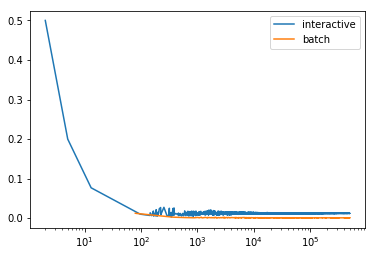

In [196]:

#for t in sorted(tp_rl.items(), key=lambda x:x[0]):
#    m, s = tp_rl[t]

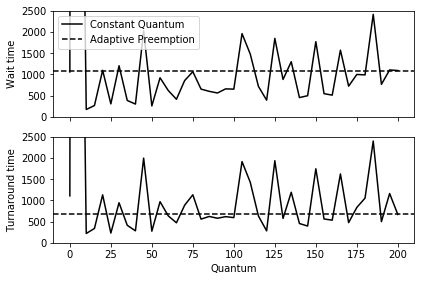

In [226]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

ax1.plot(const_qs, avgs_wt, color='k',label='Constant Quantum' )
ax2.plot(const_qs, avgs_tu,color='k')

#time, rl_wt = per_process_param_per_t(wt_per_t, ptypes,avg=True)

#plot_final_n(rl_wt, label='Reinforcement Learning')
ax1.axhline(avg_final_n(wt_rl), linestyle='--', color='k',label='Adaptive Preemption')
ax1.set_ylabel('Wait time')
ax1.set_ylim(0, 2500)
ax2.set_ylim(0, 2500)
ax2.set_ylabel('Turnaround time')
ax2.set_xlabel('Quantum')
ax2.axhline(avg_final_n(tu_rl),linestyle='--', color='k')
plt.tight_layout()
ax1.legend()
plt.savefig('turnaround_wt.pdf')
plt.show()

In [218]:
def avg_procs_completed(sims):
    """
    compute the (average across each simulation) number
    of processes completed for this quantum
    """
    procs_completed = [des.processes_completed for des in sims]
    return np.mean(procs_completed), np.std(procs_completed)

@cache_handle
def procs_completed(q):
    return [avg_procs_completed(get_sims(qdir)) for qdir in q]

def avg_wait_time(sims):
    ptypes = sims[0].factory.process_types
    #for sim in sims:
    #    sim.finalize()
    
    ptype2wt = dict()
    for ptype in ptypes:
        wt = list(reduce(lambda x1,x2: x1+x2, [des.process_stats[ptype]['wait_time'][-1000:] for des in sims]))
        ptype2wt[ptype] = (np.mean(wt),np.std(wt))
    return ptype2wt

@cache_handle
def wait_time(q):
    return [avg_wait_time(get_sims(qdir)) for qdir in q]


const_qs = [0, 1] + list(range(10,201,5))
mean_qs = [1] + list(range(10, 201,5))

def join(prefix,suffix):
    return os.path.join(prefix, suffix)

In [199]:
cpu1_procs_completed = procs_completed(os.path.join(cpu1,"procs_completed.bin"),cpu1_qs)
rl_cpu1_procs_comp = procs_completed(join(rl_cpu1,"procs_completed.bin"),rl_cpu1_qs)


batchInteractive_1cpu/DESQuantum__0200                                          cached content to batchInteractive_1cpu/procs_completed.bin
batchInteractive_1cpu_rl/DES_RL                                                 cached content to batchInteractive_1cpu_rl/procs_completed.bin


In [205]:
rl_cpu1_procs_comp

[(13507.733333333334, 156.9796023550689)]

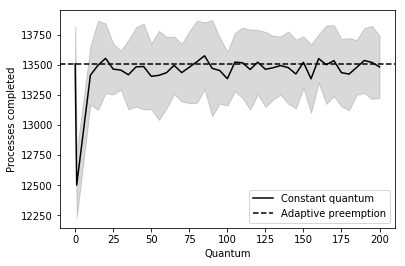

In [225]:
cpu1_procs_completed
procs_comp_m, procs_comp_s = map(np.array, zip(*cpu1_procs_completed))
plt.plot(const_qs, procs_comp_m, label='Constant quantum',color='k')
plt.fill_between(const_qs, procs_comp_m + 1.96*procs_comp_s, procs_comp_m - 1.96*procs_comp_s,alpha=0.15,color='k')
fll = np.array(rl_cpu1_procs_comp[0][0]*len(const_qs))
ci = np.array(rl_cpu1_procs_comp[0][1]*len(const_qs))*1.96
plt.axhline(rl_cpu1_procs_comp[0][0], color='k', linestyle='--', label='Adaptive preemption')
#plt.fill_between(const_qs, fll + ci, fll - ci)
plt.xlabel('Quantum')
plt.ylabel('Processes completed')
plt.legend(loc='lower right')
plt.savefig('processes_completed.pdf')
#plt.fill_between(const_qs, rl_cpu1_procs_comp[0][0] )
plt.show()

In [57]:
ppt, ptypes = param_per_t(rl_cpu3_qs, 'wait_time')[0]
time, param = per_process_param_per_t(ppt, ptypes, avg=True)

batchInteractiveMalloc_RL_3cpu_decay/DES_RL

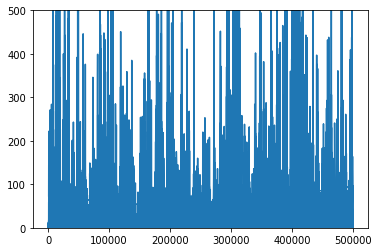

In [59]:
#for ptype in ptype2time_param:
#    plt.plot(*ptype2time_param[ptype], marker='o',alpha=0.1)
plt.plot(time, param)
plt.ylim(0,500)
plt.show()

In [9]:
# -----
#cpu1_procs_completed = procs_completed(os.path.join(cpu1,"procs_completed.bin"),cpu1_qs)
#cpu1_wt = wait_time(os.path.join(cpu1,"wait_time.bin"),cpu1_qs)
#cpu1_tp = throughput(os.path.join(cpu1, "throughput.bin"),cpu1_qs)
# -----
#cpu3_procs_completed = procs_completed(join(cpu3,"procs_completed.bin"),cpu3_qs)
#cpu3_wt = wait_time(join(cpu3,"wait_time.bin"),cpu3_qs)
#cpu3_tp = throughput(join(cpu3, "throughput.bin"),cpu3_qs)
# -----
#rl_cpu1_procs_comp = procs_completed(join(rl_cpu1,"procs_completed.bin"),rl_cpu1_qs)
#rl_cpu1_wt = wait_time(join(rl_cpu1,"wait_time.bin"),rl_cpu1_qs)
#rl_cpu1_tp = throughput(join(rl_cpu1, "throughput.bin"),rl_cpu1_qs)
# -----
#rl_cpu3_procs_comp = procs_completed(join(rl_cpu3,"procs_completed.bin"),rl_cpu3_qs)
#rl_cpu3_wt = wait_time(join(rl_cpu3,"wait_time.bin"),rl_cpu1_qs)
#rl_cpu3_tp = throughput(join(rl_cpu3, "throughput.bin"),rl_cpu1_qs)

In [10]:
#def find_best_wait_time_per_t
#best_tp_1cpus, bestwt_1cpu, best_q_1cpus = find_best_throughput_per_t(os.path.join(cpu1,'throughput_max.bin'),cpu1_tp,cpu1_wt, const_qs)
#best_tp_3cpus, bestwt_3cpu, best_q_3cpus = find_best_throughput_per_t(os.path.join(cpu3,'throughput_max.bin'),cpu3_tp,cpu1_wt, const_qs)

In [ ]:
cpu3_mean_procs_completed,cpu3_std_procs_completed = zip(*cpu3_procs_completed)
cpu1_mean_procs_completed,cpu1_std_procs_completed = zip(*cpu1_procs_completed)
rl_cpu1_procs, rl_cpu1_proc_std = zip(*rl_cpu1_procs_comp)
rl_cpu3_procs, rl_cpu3_proc_std = zip(*rl_cpu3_procs_comp)

#plt.axhline(rl_cpu1_procs, linestyle='--', label="AP, 1 CPU")# #color='k')
#plt.axhline(rl_cpu3_procs, linestyle='--', label="AP, 3 CPU")# color="C")
#plt.fill_between(const_qs,
#                np.array([]len(const_))

plt.plot(const_qs,cpu3_mean_procs_completed,label='3 CPUs',marker='o')
plt.fill_between(const_qs,
                 np.array(cpu3_mean_procs_completed) - 1.96*np.array(cpu3_std_procs_completed),
                 np.array(cpu3_mean_procs_completed) + 1.96*np.array(cpu3_std_procs_completed),
                 alpha=0.1)
plt.fill_between(const_qs,
                 np.array(cpu1_mean_procs_completed) - 1.96*np.array(cpu1_std_procs_completed),
                 np.array(cpu1_mean_procs_completed) + 1.96*np.array(cpu1_std_procs_completed),
                 alpha=0.1)
plt.plot(const_qs,cpu1_mean_procs_completed,label='1 CPU',marker='o')

plt.legend()
plt.xticks(const_qs[::3][:-1] + [const_qs[-1]], const_qs[::3][:-1] + [const_qs[-1]])
#plt.ylim(21500,22200)
plt.xlabel('Quantum value')
plt.ylabel('Processes completed')
plt.show()

In [ ]:
tp_rl_1cpu = rl_throughput(rl_cpu1_tp[0])

In [ ]:
markers = ['o','^','s']
ptypes = list(best_tp_1cpus.keys())
ptype2marker = {ptype:markers[i] for i,ptype in enumerate(ptypes)}
ptype2color  = {ptype:f"C{i}" for i,ptype in enumerate(ptypes)}

def plot_wt_per_q(ax,wt,**kwargs):
    qs = const_qs
    ptype2wt = {ptype:[] for ptype in wt[0]}
    for wt_dict in wt:
        for ptype in ptype2wt:
            ptype2wt[ptype].append(wt_dict[ptype])

    for ptype in ptype2wt:
        mean, std = zip(*ptype2wt[ptype])
        #print(mean[:5])
        ax.plot(qs, mean, label=ptype, 
                color=ptype2color[ptype],
                marker=ptype2marker[ptype],
                markersize=3.5,
                **kwargs)
        #ax.set_title(label)
        
def plot_wt(ax,best_wt,**kwargs):
    
    for ptype in best_wt:
        wait_times, std_wt = zip(*best_wt[ptype])
        ax.plot(wait_times, label=ptype,
                color=ptype2color[ptype],
                markersize=3.5,
                marker=ptype2marker[ptype],**kwargs)
        
def plot_tp(ax, best_tp, **kwargs):
    for ptype in best_tp:
        X, y = best_tp[ptype]
        X, y = X[::2], y[::2]
        ax.plot(X,y,label=ptype,
                color=ptype2color[ptype],
                markersize=3.5,
                marker=ptype2marker[ptype], **kwargs)#,marker='o',markersize=0.55,linestyle='')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_title(rf"{title} $Q = {best_q}$")
    
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlabel("$t$")
ax1.set_ylabel('Average throughput')

ax2.set_xlabel('Quantum value')
ax2.set_ylabel('Wait time')
cpu1_kw = {'alpha':0.5, 'linestyle':'--'}
cpu3_kw = {'alpha':0.5}
plot_tp(ax1,best_tp_1cpus,**cpu1_kw)
plot_tp(ax1,best_tp_3cpus,**cpu3_kw)
plot_tp(ax1,tp_rl_1cpu)
#(ax1,rl_cpu1_tp[0])
plot_wt_per_q(ax2,cpu1_wt, **cpu1_kw)
plot_wt_per_q(ax2,cpu3_wt, **cpu3_kw)
custom_lines = [Line2D([0],[0],
                       color=ptype2color[ptype],
                       marker=ptype2marker[ptype]) for ptype in ptypes]
ax1.legend(custom_lines, ptypes)
plt.tight_layout()
plt.show()

In [ ]:
wait_time_per_t_rl, ptypes = param_per_t(rl_cpu1_qs, 'turnaround')[0]
wait_time_per_t_rl = per_process_param_per_t(wait_time_per_t_rl, ptypes)